# **BrainDx – Brain Tumour Classification**

In [ ]:
# Section 1: Setup Kaggle Authentication
#-------------------------------------
from google.colab import files
import json
import os

# Install kaggle if not already installed
!pip install -q kaggle

# Create .kaggle folder if it doesn't exist
!mkdir -p ~/.kaggle

# Function to create kaggle.json
def setup_kaggle():
    print("Please enter your Kaggle credentials:")
    username = input("Kaggle username: ")
    key = input("Kaggle API key: ")

    token = {"username":username, "key":key}

    # Save to kaggle.json
    with open('kaggle.json', 'w') as file:
        json.dump(token, file)

    # Move to correct location
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    print("\nKaggle credentials set up successfully!")

# Run setup
setup_kaggle()

# Download dataset
print("\nDownloading Brain Tumor MRI dataset...")
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset --quiet
!unzip -q brain-tumor-mri-dataset.zip

print("Dataset downloaded and extracted successfully!")

Please enter your Kaggle credentials:
Kaggle username: poisonkissedsk
Kaggle API key: 122a712a61505af62a9489d1b7c8c3ae

Kaggle credentials set up successfully!

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
Dataset downloaded and extracted successfully!


In [ ]:
# Section 2: Import Required Libraries
#-----------------------------------
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Section 3: Define Data Loading Functions
#---------------------------------------
def train_df(tr_path):
    """Create DataFrame for training data"""
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    """Create DataFrame for testing data"""
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [ ]:
# Section 4: Load and Prepare Data
#--------------------------------
# Create DataFrames
tr_df = train_df('Training')
ts_df = test_df('Testing')


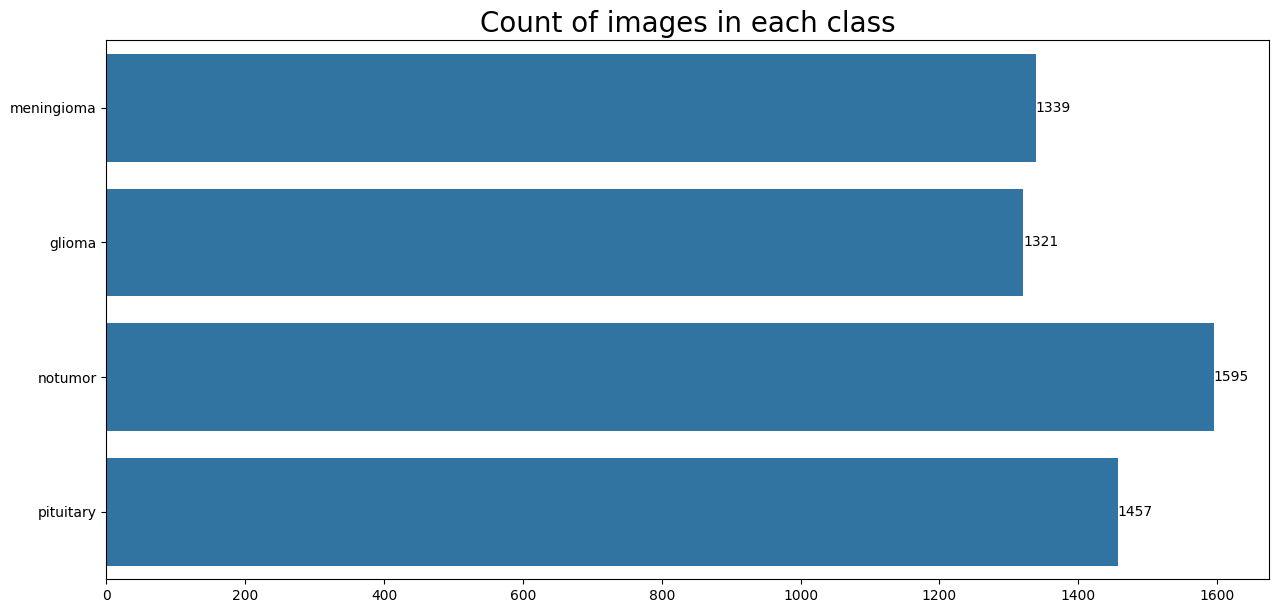

In [ ]:
# Section 5: Data Visualization
#-----------------------------
# Visualize training data distribution
plt.figure(figsize=(15,7))
ax = sns.countplot(data=tr_df, y=tr_df['Class'])
plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [ ]:
# Section 6: Data Split and Preprocessing
#--------------------------------------
# Split test data into validation and test sets
valid_df, ts_df = train_test_split(ts_df, train_size=0.5, random_state=20, stratify=ts_df['Class'])

# Set up data generators
batch_size = 32
img_size = (299, 299)

_gen = ImageDataGenerator(rescale=1/255,
                         brightness_range=(0.8, 1.2))

ts_gen = ImageDataGenerator(rescale=1/255)

tr_gen = _gen.flow_from_dataframe(tr_df, x_col='Class Path',
                                 y_col='Class', batch_size=batch_size,
                                 target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                    y_col='Class', batch_size=batch_size,
                                    target_size=img_size)

ts_gen = ts_gen.flow_from_dataframe(ts_df, x_col='Class Path',
                                   y_col='Class', batch_size=16,
                                   target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [ ]:
# Section 7: Model Building
#-------------------------
img_shape = (299, 299, 3)
base_model = tf.keras.applications.Xception(include_top=False,
                                          weights="imagenet",
                                          input_shape=img_shape,
                                          pooling='max')

model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

model.compile(Adamax(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy',
                     Precision(),
                     Recall()])

# Print model summary
model.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,124,268 (80.58 MB)

 Trainable params: 21,069,740 (80.37 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [ ]:
# Section 8: Model Training
#-------------------------
hist = model.fit(tr_gen,
                epochs=10,
                validation_data=valid_gen,
                shuffle=False)

Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 274s 1s/step - accuracy: 0.7996 - loss: 0.5968 - precision: 0.8635 - recall: 0.7191 - val_accuracy: 0.9389 - val_loss: 0.2195 - val_precision: 0.9473 - val_recall: 0.9328
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 148s 825ms/step - accuracy: 0.9804 - loss: 0.0690 - precision: 0.9815 - recall: 0.9792 - val_accuracy: 0.9466 - val_loss: 0.1481 - val_precision: 0.9565 - val_recall: 0.9389
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 202s 827ms/step - accuracy: 0.9894 - loss: 0.0284 - precision: 0.9903 - recall: 0.9893 - val_accuracy: 0.9756 - val_loss: 0.0845 - val_precision: 0.9755 - val_recall: 0.9725
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 148s 827ms/step - accuracy: 0.9968 - loss: 0.0136 - precision: 0.9973 - recall: 0.9968 - val_accuracy: 0.9847 - val_loss: 0.0553 - val_precision: 0.9847 - val_recall: 0.9832
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 148s 826ms/step - accuracy: 0.9947 - loss: 0.0219 - precision: 0.9950 - recall: 0.9947 - val_accuracy: 0.99

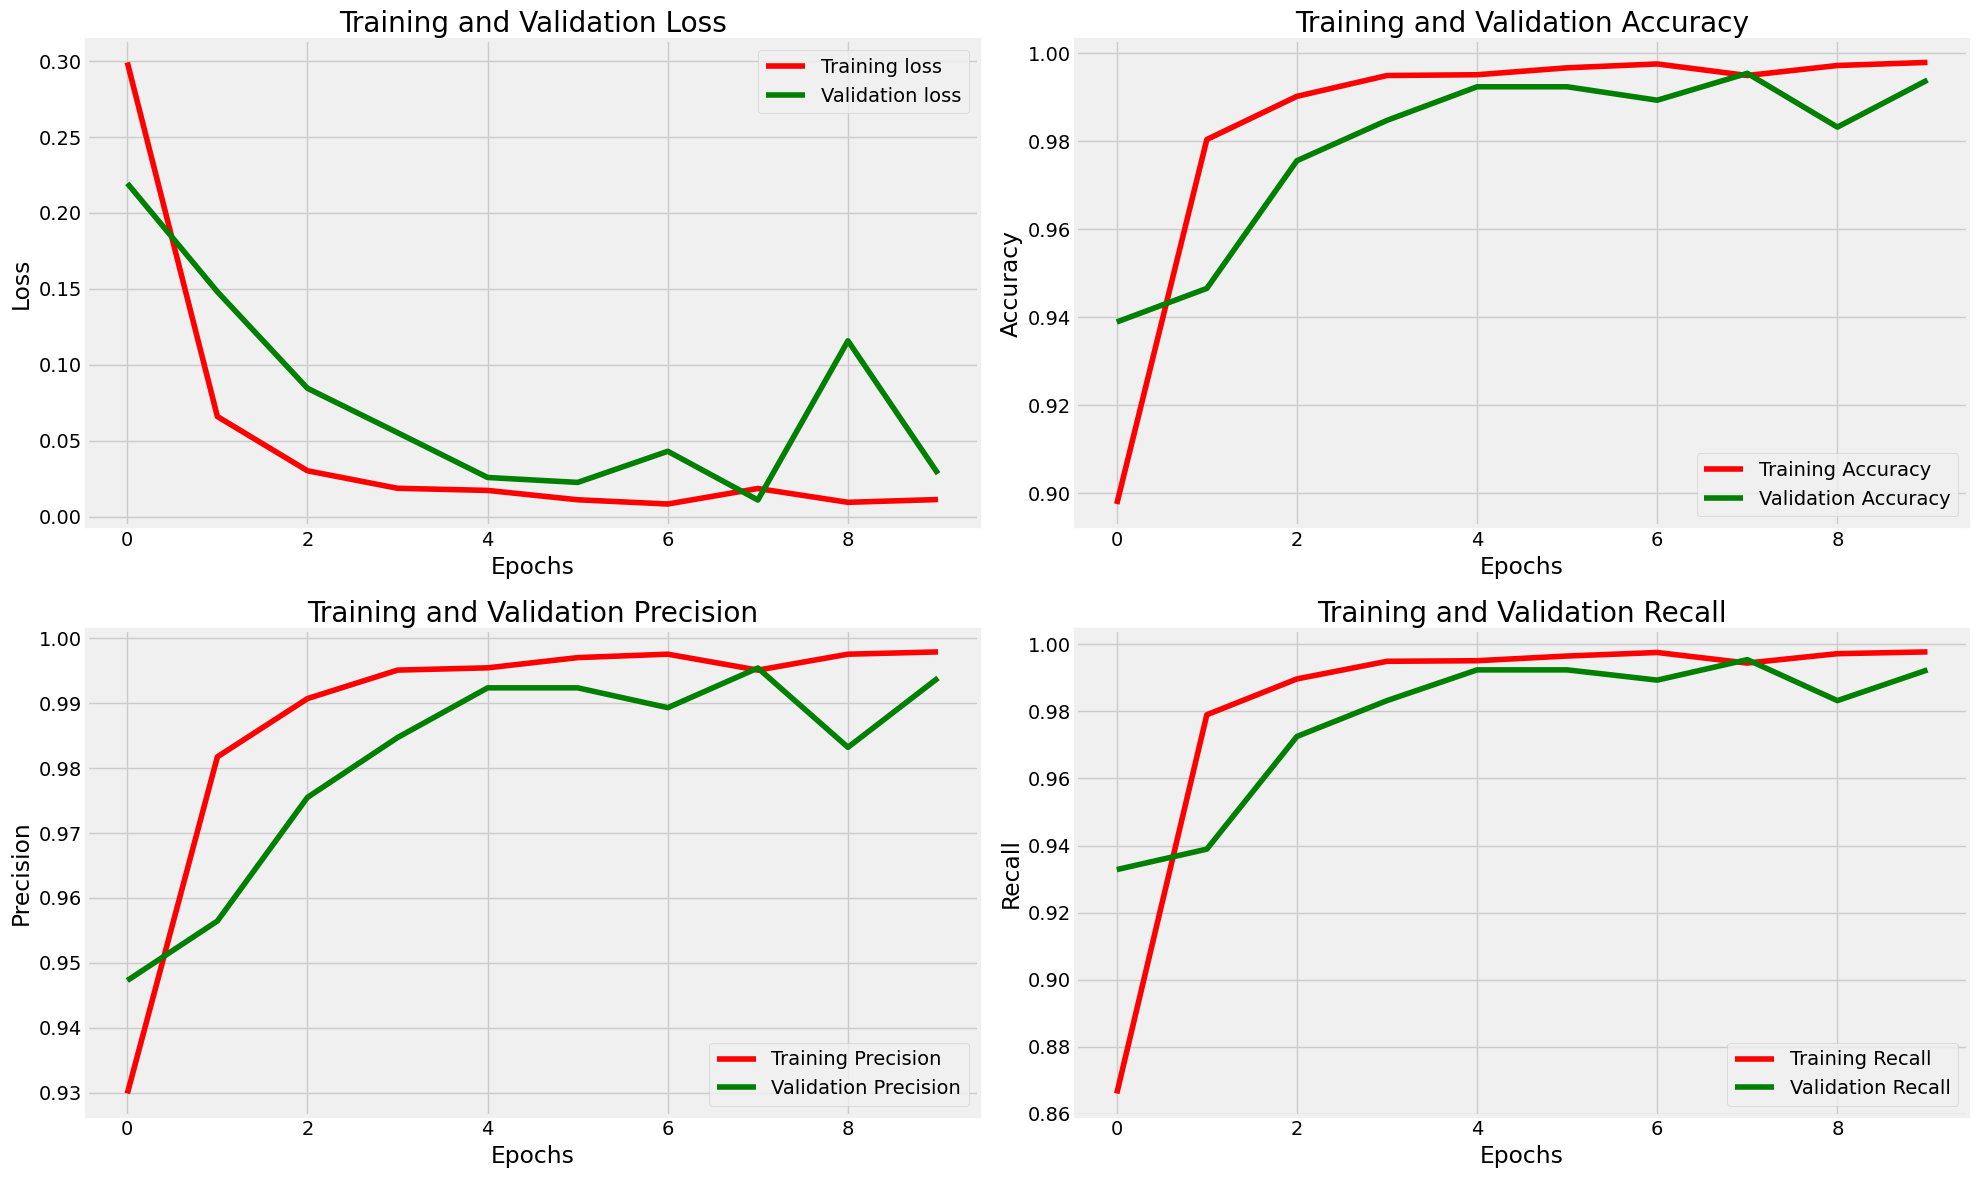

In [ ]:
# Section 9: Training Visualization
#--------------------------------
tr_acc = hist.history['accuracy']
tr_loss = hist.history['loss']
tr_per = hist.history['precision']
tr_recall = hist.history['recall']
val_acc = hist.history['val_accuracy']
val_loss = hist.history['val_loss']
val_per = hist.history['val_precision']
val_recall = hist.history['val_recall']

# Create visualization
plt.figure(figsize=(20, 12))
plt.style.use('fivethirtyeight')

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(tr_loss, 'r', label='Training loss')
plt.plot(val_loss, 'g', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(tr_acc, 'r', label='Training Accuracy')
plt.plot(val_acc, 'g', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision
plt.subplot(2, 2, 3)
plt.plot(tr_per, 'r', label='Training Precision')
plt.plot(val_per, 'g', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot Recall
plt.subplot(2, 2, 4)
plt.plot(tr_recall, 'r', label='Training Recall')
plt.plot(val_recall, 'g', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Section 10: Model Evaluation
#---------------------------
train_score = model.evaluate(tr_gen, verbose=1)
valid_score = model.evaluate(valid_gen, verbose=1)
test_score = model.evaluate(ts_gen, verbose=1)

print("\nModel Performance:")
print(f"Train Loss: {train_score[0]:.4f}")
print(f"Train Accuracy: {train_score[1]*100:.2f}%")
print('-' * 20)
print(f"Validation Loss: {valid_score[0]:.4f}")
print(f"Validation Accuracy: {valid_score[1]*100:.2f}%")
print('-' * 20)
print(f"Test Loss: {test_score[0]:.4f}")
print(f"Test Accuracy: {test_score[1]*100:.2f}%")

179/179 ━━━━━━━━━━━━━━━━━━━━ 46s 257ms/step - accuracy: 0.9995 - loss: 0.0025 - precision: 0.9995 - recall: 0.9995
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.9893 - loss: 0.0300 - precision: 0.9893 - recall: 0.9893
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.9942 - loss: 0.0354 - precision: 0.9942 - recall: 0.9942

Model Performance:
Train Loss: 0.0017
Train Accuracy: 99.96%
--------------------
Validation Loss: 0.0332
Validation Accuracy: 99.24%
--------------------
Test Loss: 0.0491
Test Accuracy: 99.39%


Testing predictions on sample images...


Testing image: Testing/glioma/Te-glTr_0000.jpg
--------------------------------------------------


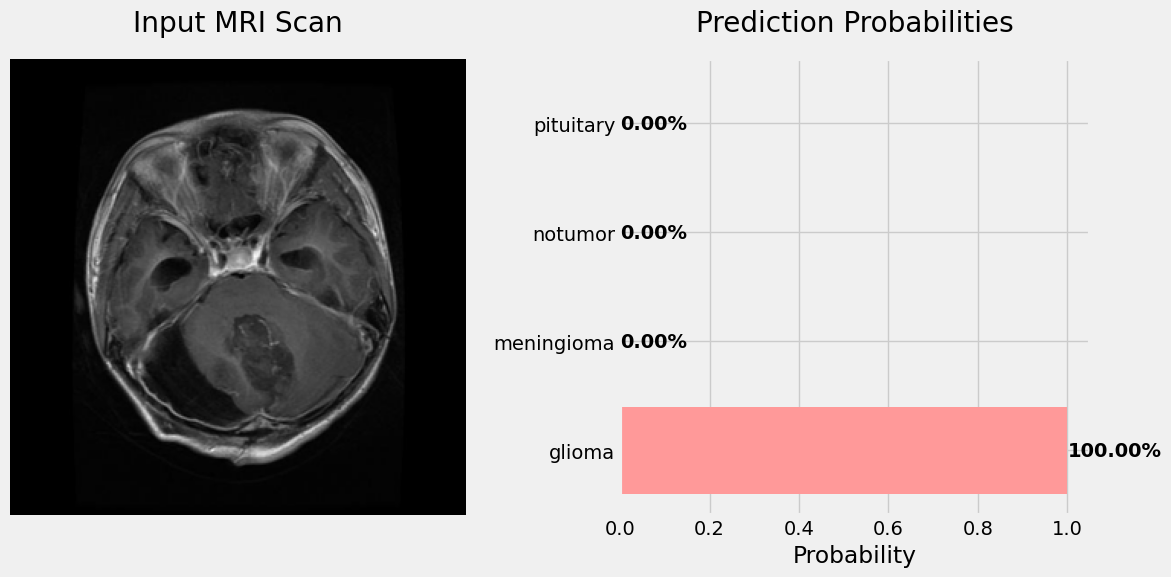


Prediction Results:
--------------------------------------------------
Predicted Class: glioma
--------------------------------------------------
Class Probabilities:
glioma: 100.00%
meningioma: 0.00%
notumor: 0.00%
pituitary: 0.00%



Testing image: Testing/meningioma/Te-me_0064.jpg
--------------------------------------------------


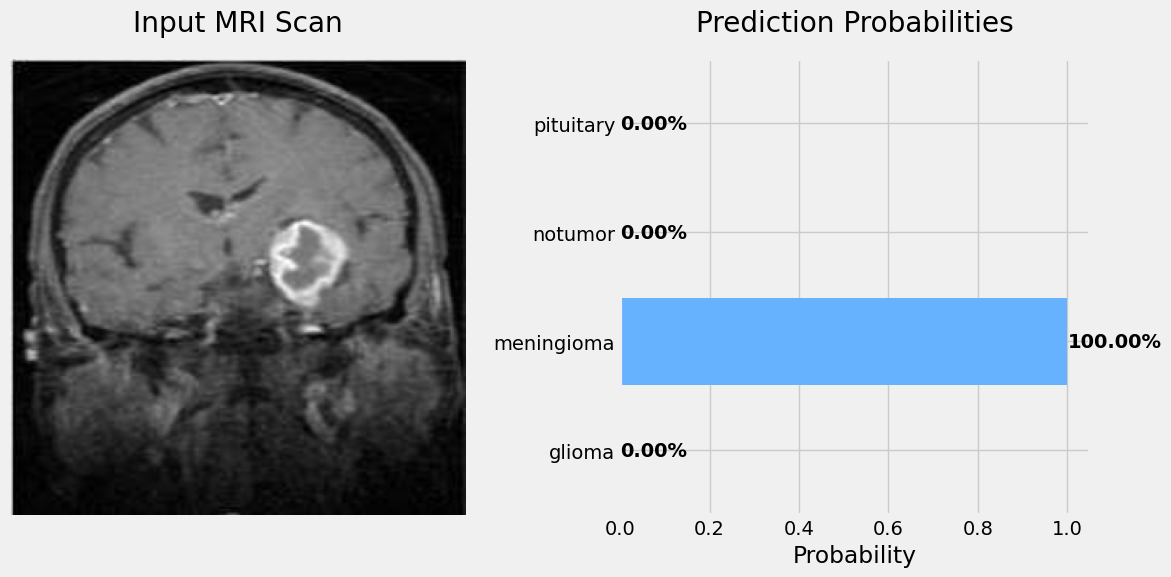


Prediction Results:
--------------------------------------------------
Predicted Class: meningioma
--------------------------------------------------
Class Probabilities:
glioma: 0.00%
meningioma: 100.00%
notumor: 0.00%
pituitary: 0.00%



Testing image: Testing/notumor/Te-no_0349.jpg
--------------------------------------------------


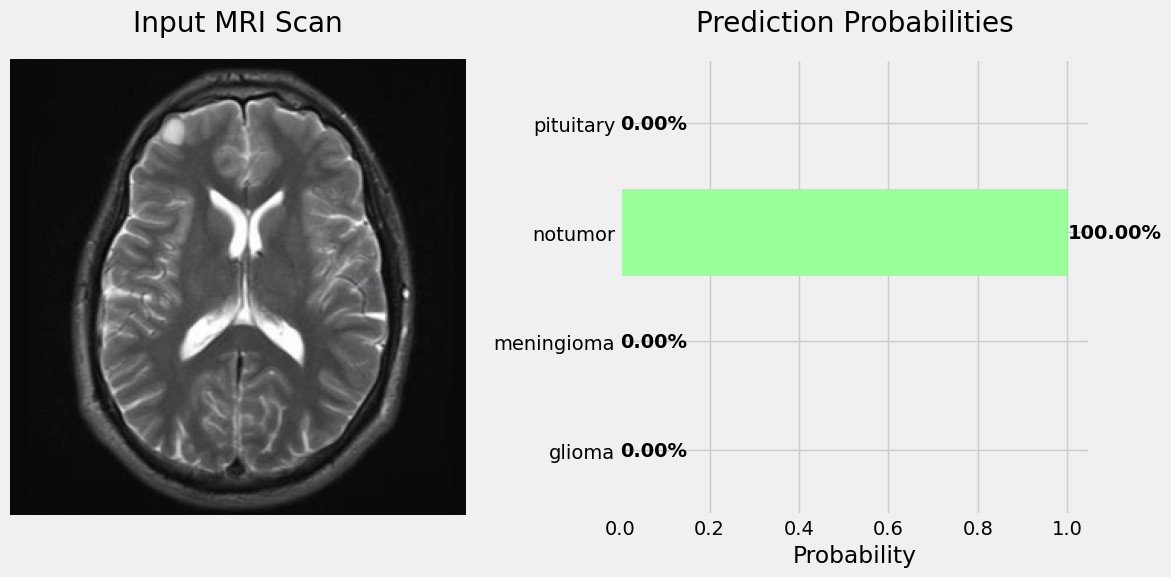


Prediction Results:
--------------------------------------------------
Predicted Class: notumor
--------------------------------------------------
Class Probabilities:
glioma: 0.00%
meningioma: 0.00%
notumor: 100.00%
pituitary: 0.00%



Testing image: Testing/pituitary/Te-pi_0110.jpg
--------------------------------------------------
Error in prediction: Exception encountered when calling Sequential.call().

Cannot take the length of shape with unknown rank.

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None




In [ ]:
# Enhanced prediction function with sample test images
def predict_tumor(img_path):
    """
    Make prediction for a brain MRI image
    Args:
        img_path: Path to the image file
    """
    try:
        # Load and preprocess image
        img = Image.open(img_path)
        resized_img = img.resize((299, 299))
        img_array = np.asarray(resized_img)
        img_array = img_array / 255.0  # Normalize
        img_array = np.expand_dims(img_array, axis=0)

        # Make prediction
        predictions = model.predict(img_array, verbose=0)
        probs = predictions[0]
        predicted_class = np.argmax(probs)
        labels = list(tr_gen.class_indices.keys())

        # Create visualization
        plt.figure(figsize=(12, 6))

        # Plot original image
        plt.subplot(1, 2, 1)
        plt.imshow(resized_img)
        plt.title('Input MRI Scan', pad=20)
        plt.axis('off')

        # Plot probability bars
        plt.subplot(1, 2, 2)
        colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']
        bars = plt.barh(labels, probs, color=colors)
        plt.xlabel('Probability')
        plt.title('Prediction Probabilities', pad=20)

        # Add probability values on bars
        for bar in bars:
            width = bar.get_width()
            plt.text(width, bar.get_y() + bar.get_height()/2,
                    f'{width:.2%}',
                    ha='left', va='center', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Print prediction results
        print("\nPrediction Results:")
        print("-" * 50)
        print(f"Predicted Class: {labels[predicted_class]}")
        print("-" * 50)
        print("Class Probabilities:")
        for label, prob in zip(labels, probs):
            print(f"{label}: {prob:.2%}")

    except Exception as e:
        print(f"Error in prediction: {str(e)}")

# Test the prediction function with sample images
def test_predictions():
    """
    Test the prediction function with sample images from each class
    """
    print("Testing predictions on sample images...\n")

    # Get one sample image from each class in the test set
    test_images = []
    for class_name in tr_gen.class_indices.keys():
        class_path = os.path.join('Testing', class_name)
        if os.path.exists(class_path):
            images = os.listdir(class_path)
            if images:
                test_images.append(os.path.join(class_path, images[0]))

    # Make predictions
    for img_path in test_images:
        print(f"\nTesting image: {img_path}")
        print("-" * 50)
        predict_tumor(img_path)
        print("\n" + "="*70 + "\n")

# Example usage
# Run this to test predictions on sample images from each class
test_predictions()

# To predict a single image, use:
# predict_tumor('path_to_your_image.jpg')